<a href="https://colab.research.google.com/github/FilipSagalara/MasterThesis_SNN_frameworks/blob/main/Rockpool_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# - Install required packages
import sys
!{sys.executable} -m pip install --quiet rockpool tonic tqdm torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.3/486.3 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00


In [2]:
# - Basic imports
import torch
import torchvision

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange

from IPython.display import Image

<ipython-input-2-d245959bf876>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
import time

class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time

    def get_execution_time(self):
        return self.execution_time


    

# Display hardware info

In [4]:
import os
import re
cpu_info = os.popen('lscpu |grep \'Model name\'').read()
cpu_thread_info = os.popen('lscpu | grep \'Thread(s) per core\'').read()
cpu_core_info = os.popen('scpu | grep \'Core(s) per socket:\'').read()
cpu_cache_info = os.popen('lscpu | grep "L3 cache" ').read()
cpu_hz_info = os.popen('lscpu | grep "MHz"').read()
memory_available = os.popen('free -h --si | awk  \'/Mem:/{print $2}\'').read()
graphic_info = os.popen('nvidia-smi').read()

hardware_info = [cpu_info,cpu_thread_info, cpu_core_info, cpu_cache_info, cpu_hz_info, memory_available, graphic_info]
print(cpu_info)
print(cpu_thread_info)
print(cpu_core_info)
print(cpu_cache_info)
print(cpu_hz_info)
print(graphic_info)



Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz

Thread(s) per core:              2


L3 cache:                        38.5 MiB

CPU MHz:                         2200.210

Tue May 16 19:29:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |    

# Set batch size

In [5]:
# - Number of samples per batch
batch_size = 256

# Set training data & test data

In [6]:
# - Download and access the MNIST training dataset
train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# - Create a data loader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=False
)

# - Create a test dataset
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
)



100%|██████████| 9912422/9912422 [00:00<00:00, 138614813.26it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31204454.87it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39331710.96it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6975660.48it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [7]:
def show_dataset(data, targets, num_of_images = 32):
  rows = 4
  cols = 8
  total_pictures = rows * cols
  plt.figure(figsize=(16,8))
  for img in range(total_pictures):
      plt.subplot(rows, cols, 1+img)
      plt.title(targets[img])
      plt.imshow(data[img])
      plt.axis('off')

# Show train data

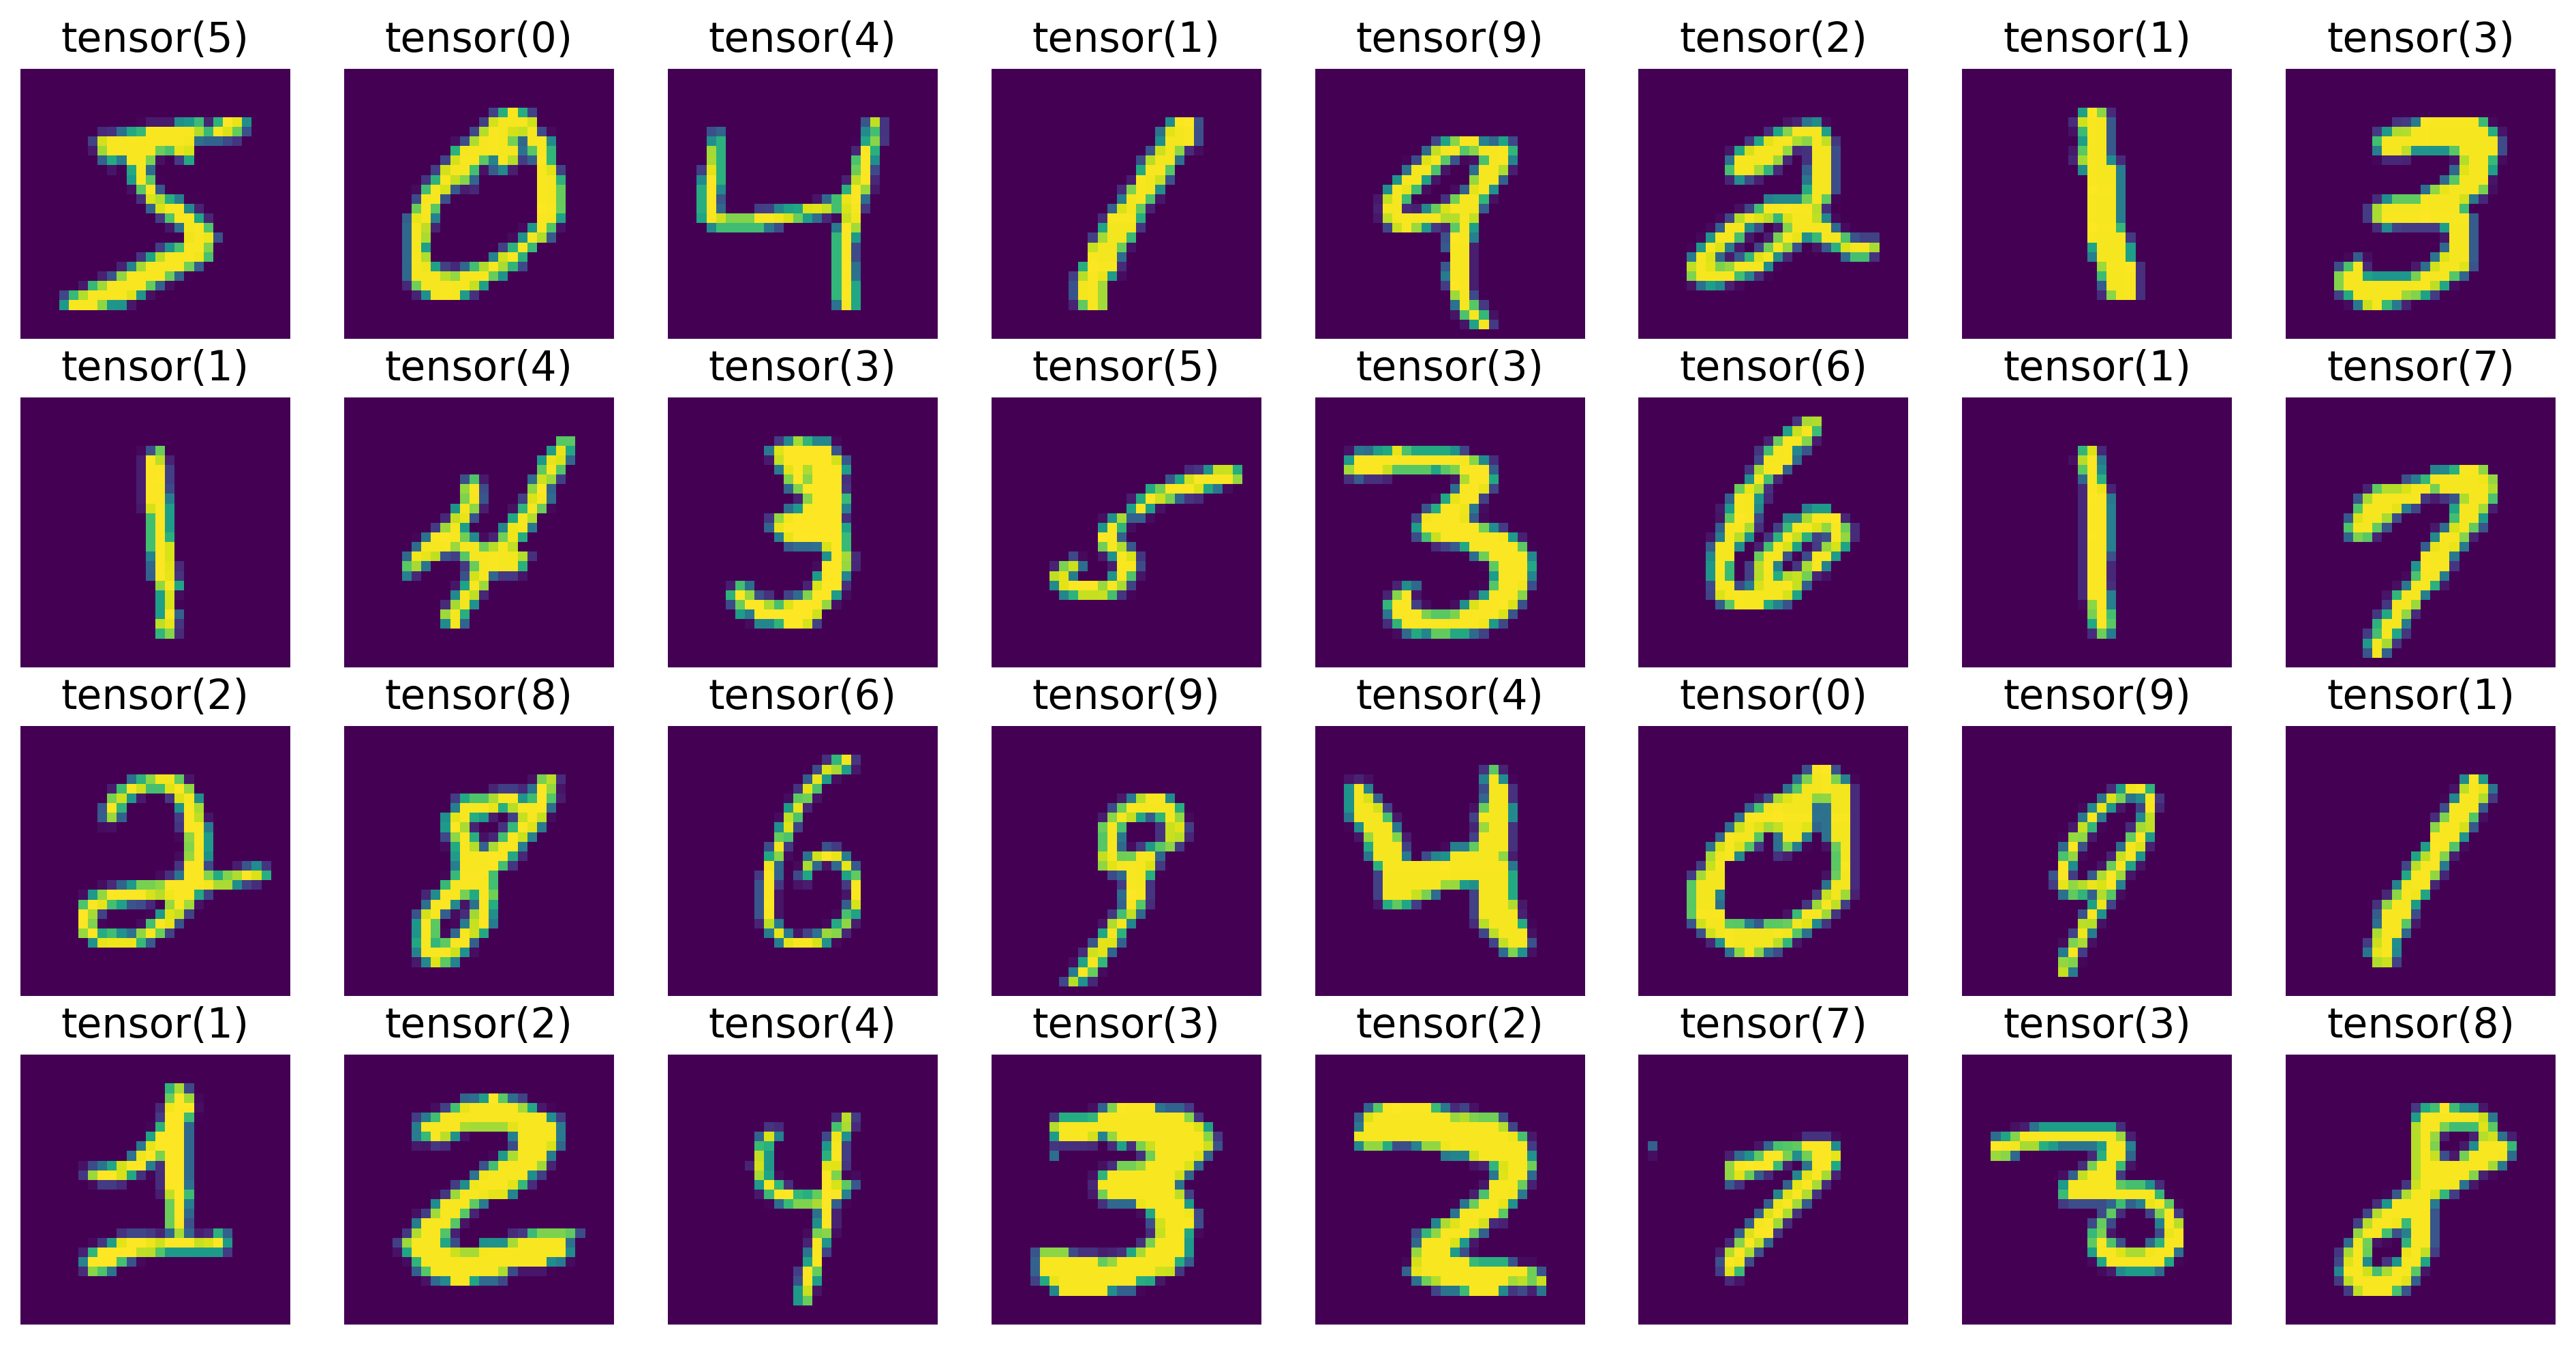

In [8]:


train_images_to_show = train_data.data
train_labels_to_show = train_data.targets
show_dataset(train_images_to_show, train_labels_to_show)

#Show test data

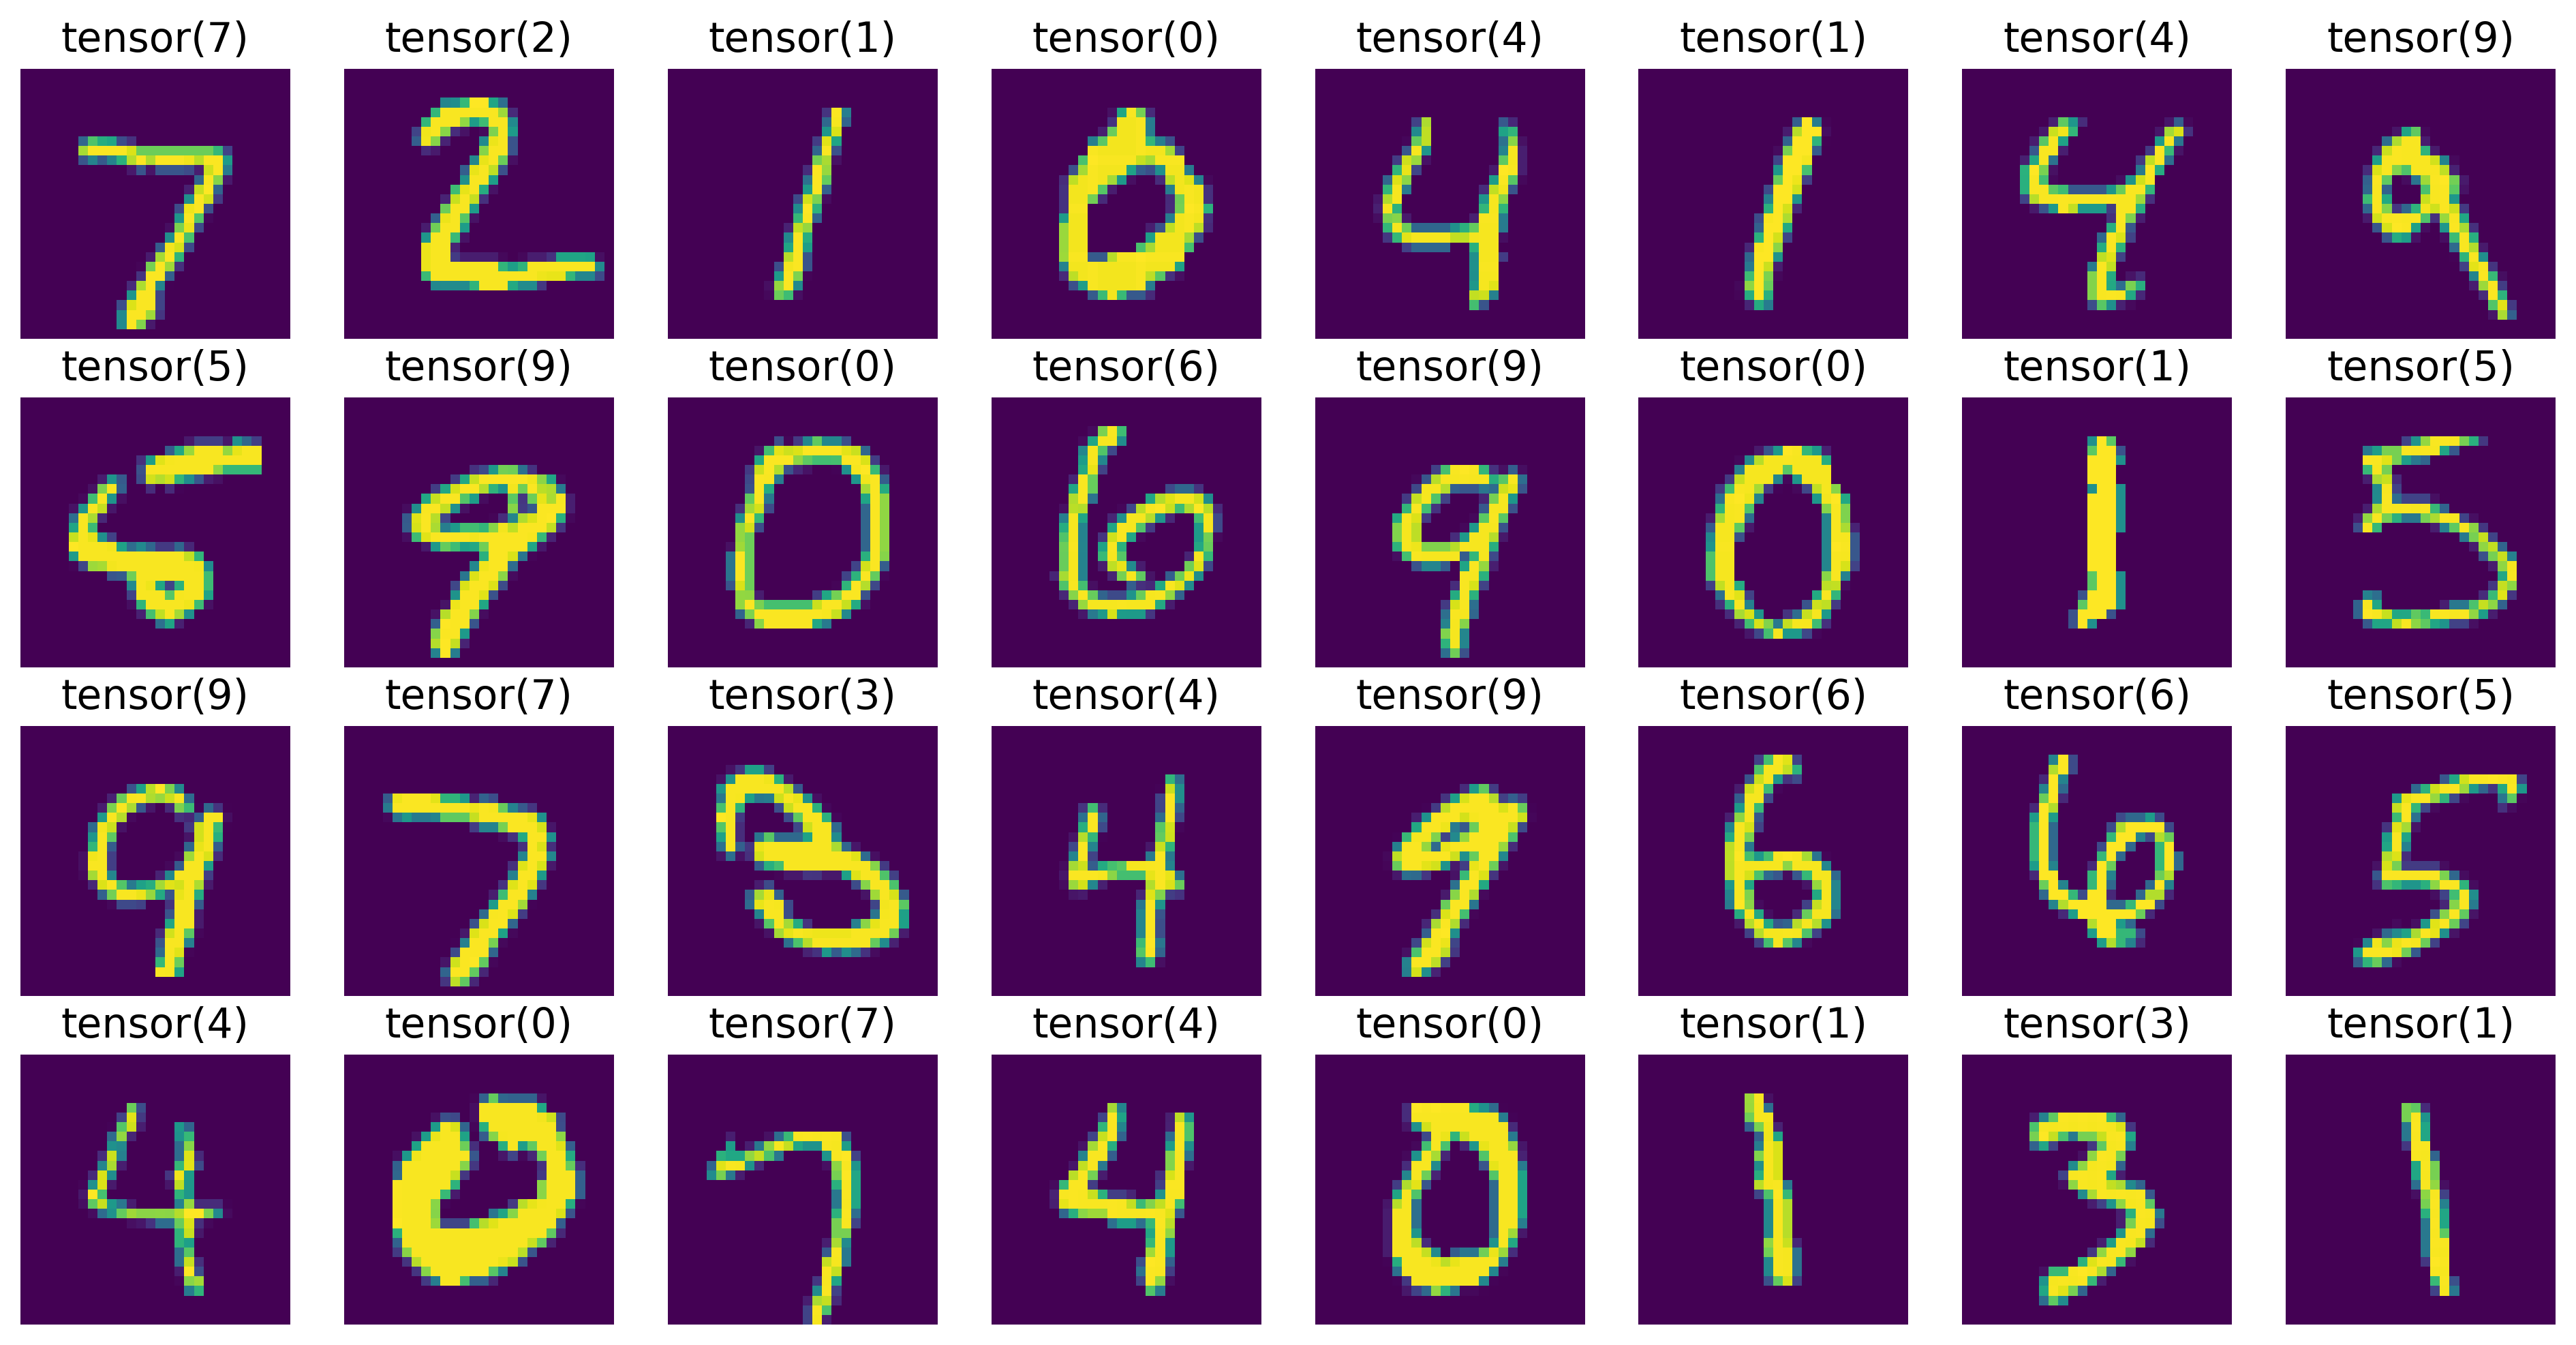

In [9]:
test_images_to_show = test_loader.dataset.data
test_labels_to_show = test_loader.dataset.targets
show_dataset(test_images_to_show, test_labels_to_show)

In [10]:
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF

# - Generate a spiking neuron
neuron = LIF(1)

# - Simulate this neuron for 1 sec with poisson spiking input z(t)
num_timesteps = int(1/neuron.dt)
input_z = 0.06 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# - Display the input, internal state and output events
# plt.figure()
# plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
# plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
# b, t, n = np.nonzero(output)
# plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$') 
# plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\Theta$')
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$, $I_s$ (a.u.)')
# plt.legend();

# Define encoding functions

In [11]:
# - Define the temporal aspects of a data sample
num_timesteps = 100
dt = 10e-3

# - Extract the number of classes and input channels
num_classes = len(torchvision.datasets.MNIST.classes)
input_channels = train_data[0][0].numel()

# - Define a function to encode an input into a poisson event series
def encode_poisson(data: torch.Tensor, num_timesteps: int, scale: float = 0.1) -> torch.Tensor:
  num_batches, frame_x, frame_y = data.shape
  data = scale * data.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
  return (torch.rand(data.shape) < (data * scale)).float()

# - Define a function to encode the network target
def encode_class(class_idx: torch.Tensor, num_classes: int, num_timesteps: int) -> torch.Tensor:
  num_batches = class_idx.numel()
  target = torch.nn.functional.one_hot(class_idx, num_classes = num_classes)
  return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()

In [12]:
# - Get one sample
frame, class_idx = train_data[0]

# - Encode the input and targets
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# # - Plot the poisson input for this sample
# plt.figure()
# b, t, n = torch.nonzero(data, as_tuple = True)
# plt.scatter(t * dt, n, marker = '|')
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Input')

# # - Plot the target event series for this sample
# b, t, n = torch.nonzero(target, as_tuple = True)
# plt.figure()
# plt.scatter(t * dt, n, marker = '|')
# plt.ylim([-1, num_classes+1])
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Target');

#Define network

In [13]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_hidden = 64
tau_mem = Constant(100e-3)
tau_syn = Constant(50e-3)
threshold = Constant(1.)
bias = Constant(0.)

# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden)),
    LIFTorch(num_hidden, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),

    LinearTorch((num_hidden, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (784, 10) {
    LinearTorch '0_LinearTorch' with shape (784, 64)
    LIFTorch '1_LIFTorch' with shape (64, 64)
    LinearTorch '2_LinearTorch' with shape (64, 10)
    LIFTorch '3_LIFTorch' with shape (10, 10)
}


In [14]:
# - Simulate the untrained network, record internal state
output, _, rec_dict = snn(data, record = True)

# # - Display the internal state and output
# plt.plot(rec_dict['1_LIFTorch']['vmem'][0].detach());
# plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
# plt.ylim([-2.1, 1.1])
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$ (a.u.)')
# plt.title('Hidden $V_m$')

# plt.figure()
# plt.plot(rec_dict['3_LIFTorch']['vmem'][0].detach());
# plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
# plt.ylim([-2.1, 1.1])
# plt.xlabel('Time (dt)')
# plt.ylabel('$V_m$ (a.u.)')
# plt.title('Output $V_m$')

# plt.figure()
# t, n = torch.nonzero(rec_dict['3_LIFTorch_output'][0].detach(), as_tuple = True)
# plt.scatter(t, n, marker = '|', label='Output events')
# plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
# plt.ylim([-1, num_classes+1])
# plt.xlim([-1, num_timesteps+1])
# plt.xlabel('Time (dt)')
# plt.ylabel('Channel')
# plt.title('Output (events)')
# plt.legend();

In [15]:
from torch.optim.adam import Adam

# - Initialise the optimizer with the network parameters
optimizer = Adam(snn.parameters().astorch())

# Use GPU

In [16]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
def train(model, device, train_loader, optimizer):
  # - Prepare model for training
  model.train()
  losses = []
  accuracy = []
  time_per_epochs = []
  
  # Count correct predictions in training
  correct = 0
  # - Loop over the dataset for this epoch
  for data, class_idx in tqdm(train_loader, leave=False, desc='Training', unit='batch'):
    # - Encode input and target
    data = encode_poisson(data.squeeze(), num_timesteps)
    target = encode_class(class_idx, num_classes, num_timesteps)

    # - Zero gradients, simulate model
    optimizer.zero_grad()
    output, _, _ = model(data.to(device))

    # - Compute MSE loss and perform backward pass
    loss = torch.nn.functional.mse_loss(output, target.to(device))
    loss.backward()
    optimizer.step()
    
    # - Compute Accuracy 
    pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
    correct += pred.eq(class_idx.view_as(pred)).sum().item()
    
    # - Keep track of the losses
    losses.append(loss.item())

  acc = 100.0 * correct / len(test_loader.dataset)


  return losses

In [18]:

def test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        input = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(input.to(device))

        # - Compute loss and prediction
        test_loss += torch.nn.functional.mse_loss(output, target.to(device)).item()
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [19]:
# - Initial loss and accuracy
test_loss, test_acc = test(snn.to(device), device, test_loader)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%')

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Initial test loss 0.0004293035343289375, accuracy 9.91%


# Set num of epochs

In [20]:
# - Train some epochs
num_epochs = 10

# Training

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/235 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

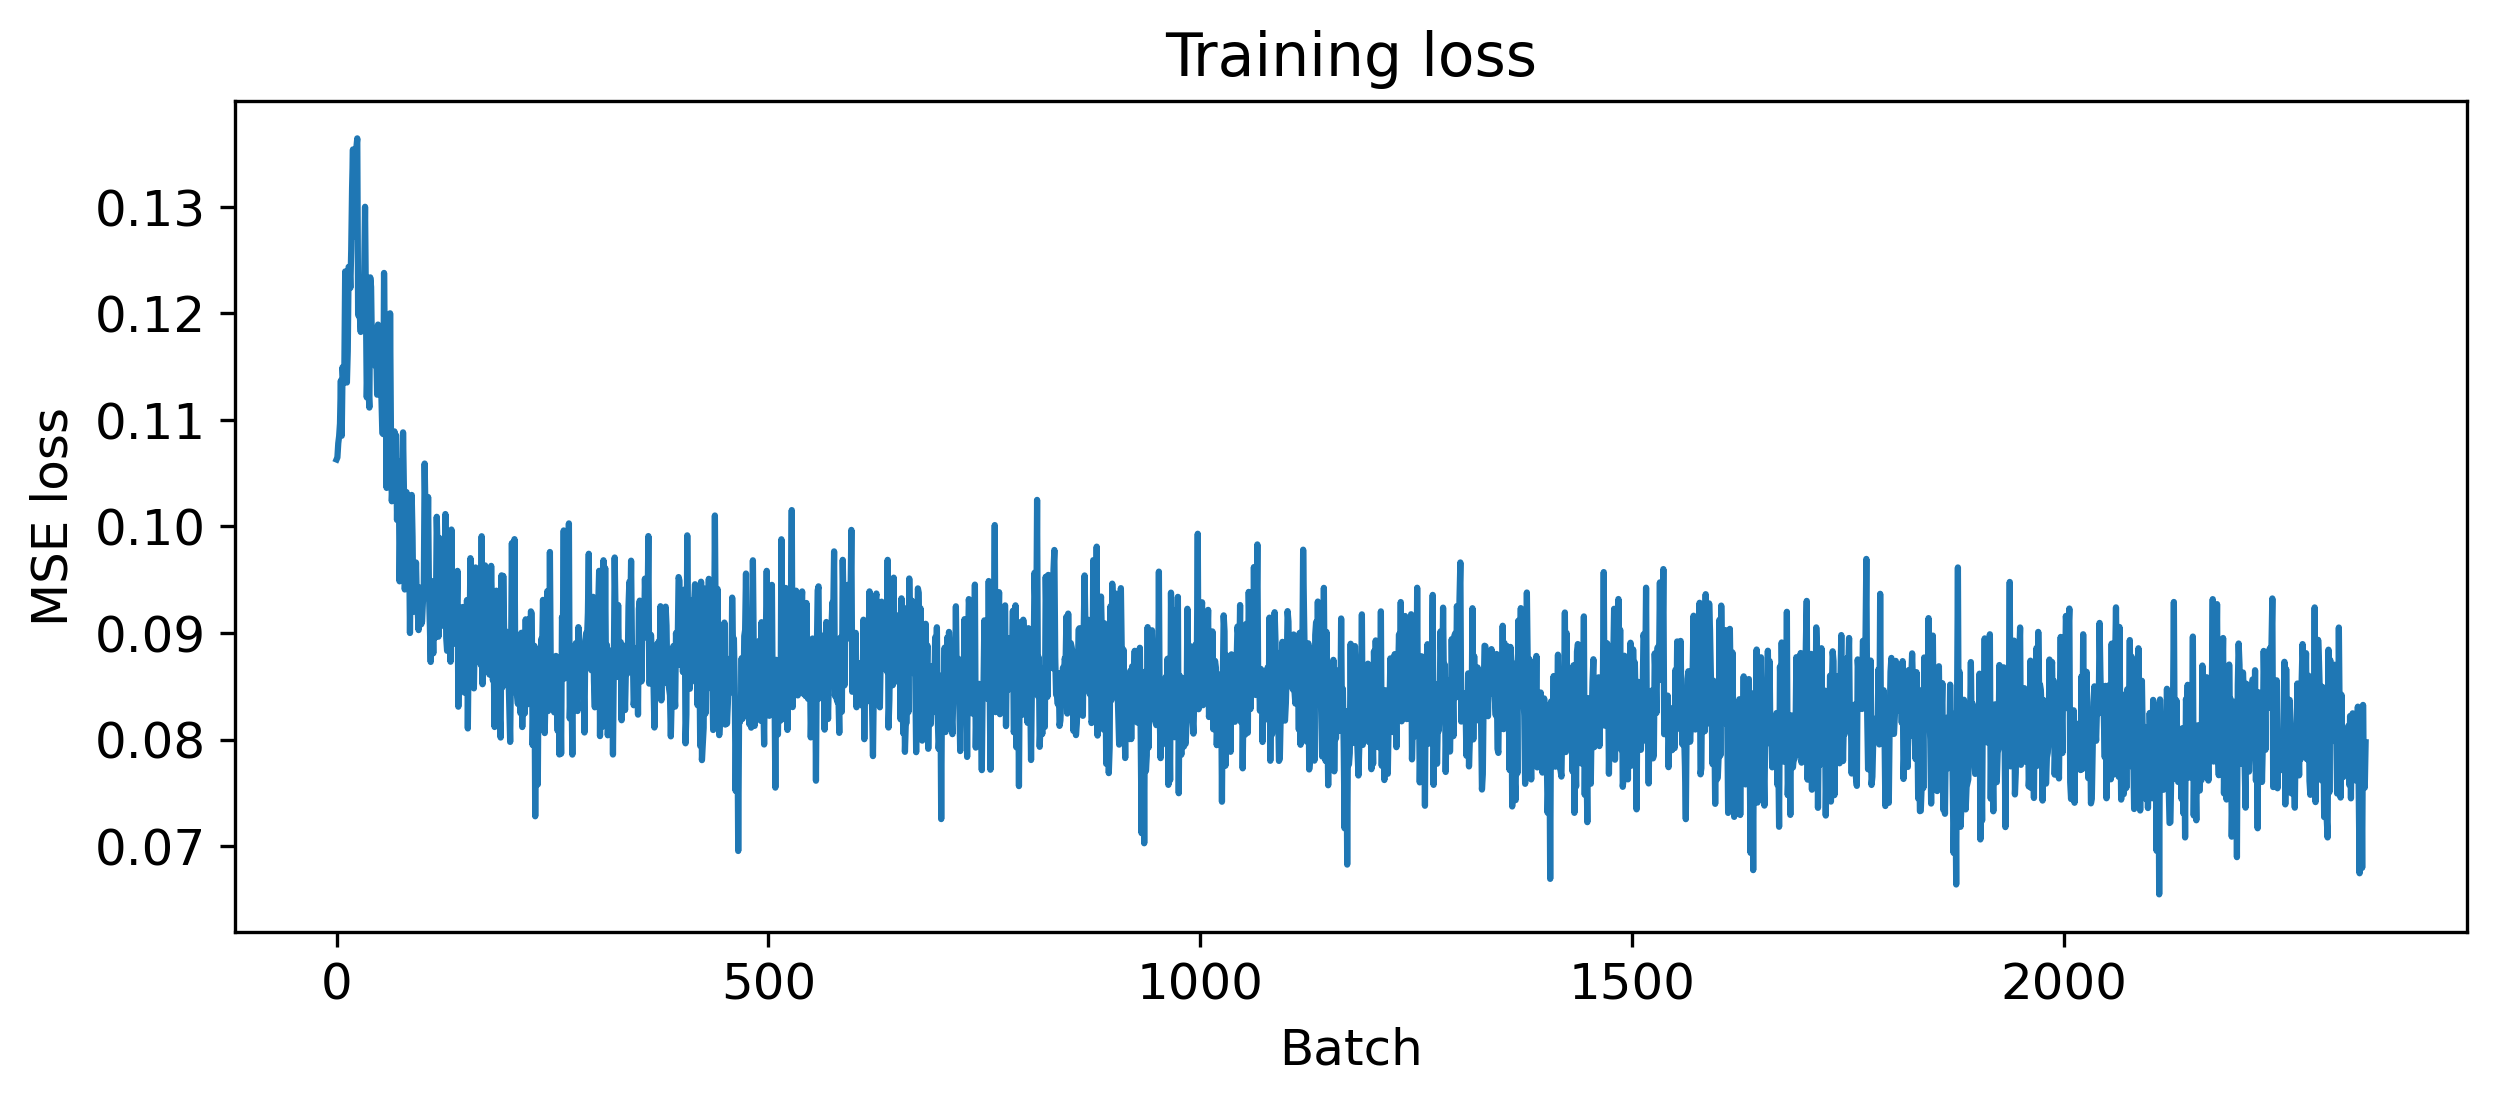

In [21]:
# Model metrics data
all_losses = []
all_accuracy_per_epoch = []
all_loss_per_epoch = []
time_per_epoch = []


ep_loop = trange(num_epochs, desc='Training', unit='epoch')
for epoch in ep_loop:
  ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
  with Timer() as t:
    losses = train(snn.to(device), device, train_loader, optimizer)
    
  #Get all losses
  all_losses.extend(losses)
  # - Get test loss and accuracy
  test_loss, test_acc = test(snn.to(device), device, test_loader)
  # Get training accuracy per epoch
  all_accuracy_per_epoch.append(test_acc)
  # Get training loss per epoch
  all_loss_per_epoch.append(test_loss)
  # Get time per epoch
  time_per_epoch.append(t.get_execution_time())

plt.plot(all_losses)
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.title('Training loss');



# My functions

## Show training time per epoch

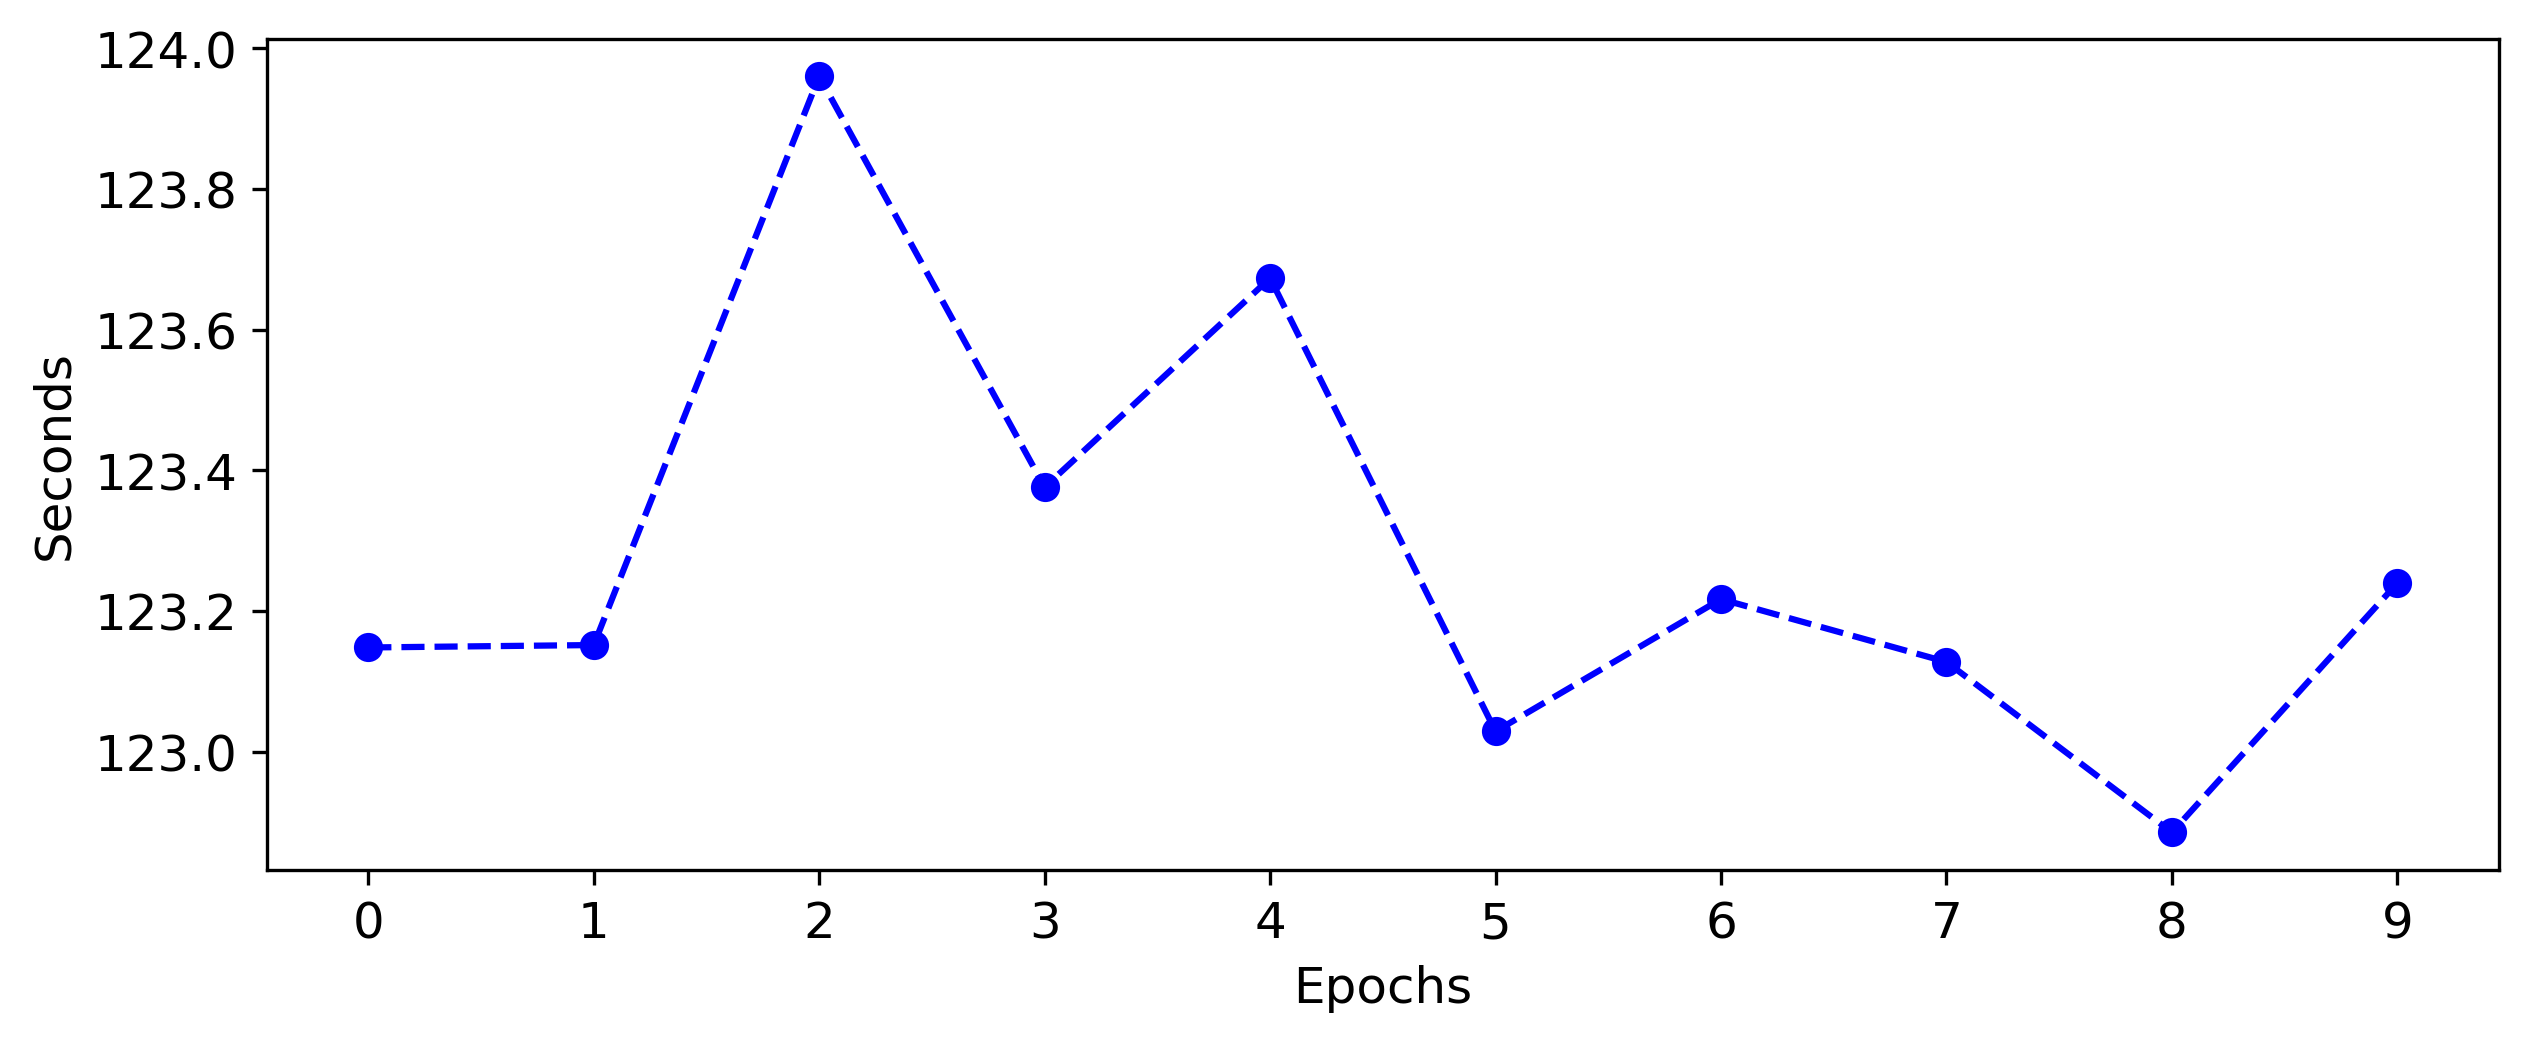

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def show_training_time(time_per_epoch):
  y = np.array(time_per_epoch)
  x = np.array(range(0, len(time_per_epoch)))

  plt.plot(x,y, 'bo--')
  plt.xticks(ticks=x)
  plt.ylabel('Seconds')
  plt.xlabel('Epochs')
  plt.show()
    
show_training_time(time_per_epoch)

## Show training accuracy

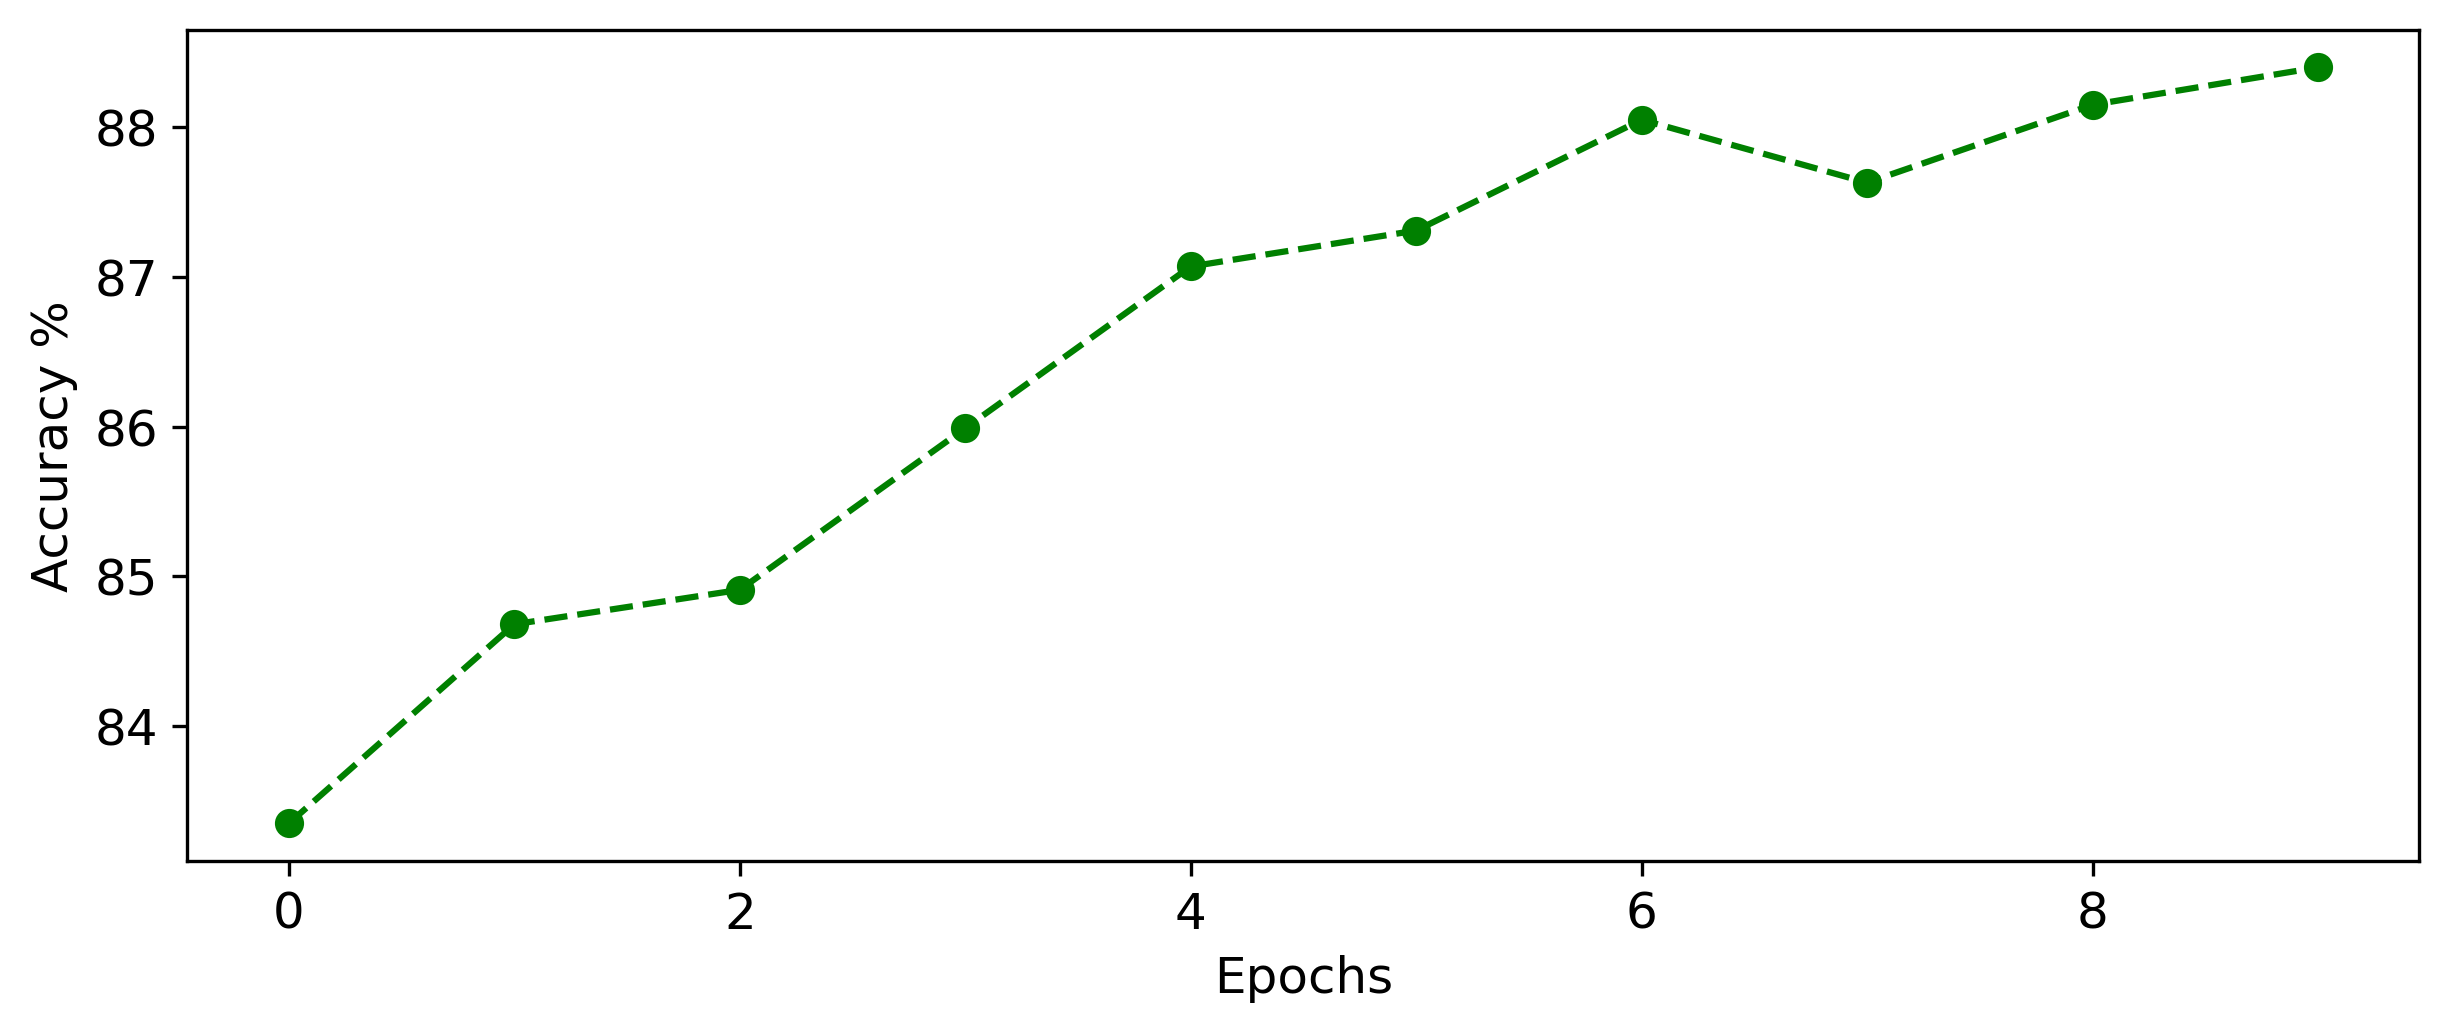

In [23]:
def show_training_accuracy(accuracy_per_epoch):
  in_percentage = [acc/100 for acc in accuracy_per_epoch]
  x= np.arange(len(in_percentage))
  # plt.scatter(x,accuracy_per_epoch)
  plt.plot(x,accuracy_per_epoch, 'go--')
  # plt.xticks(ticks=x)
  plt.ylabel('Accuracy %')
  plt.xlabel('Epochs')
  plt.show()
    

show_training_accuracy(all_accuracy_per_epoch)

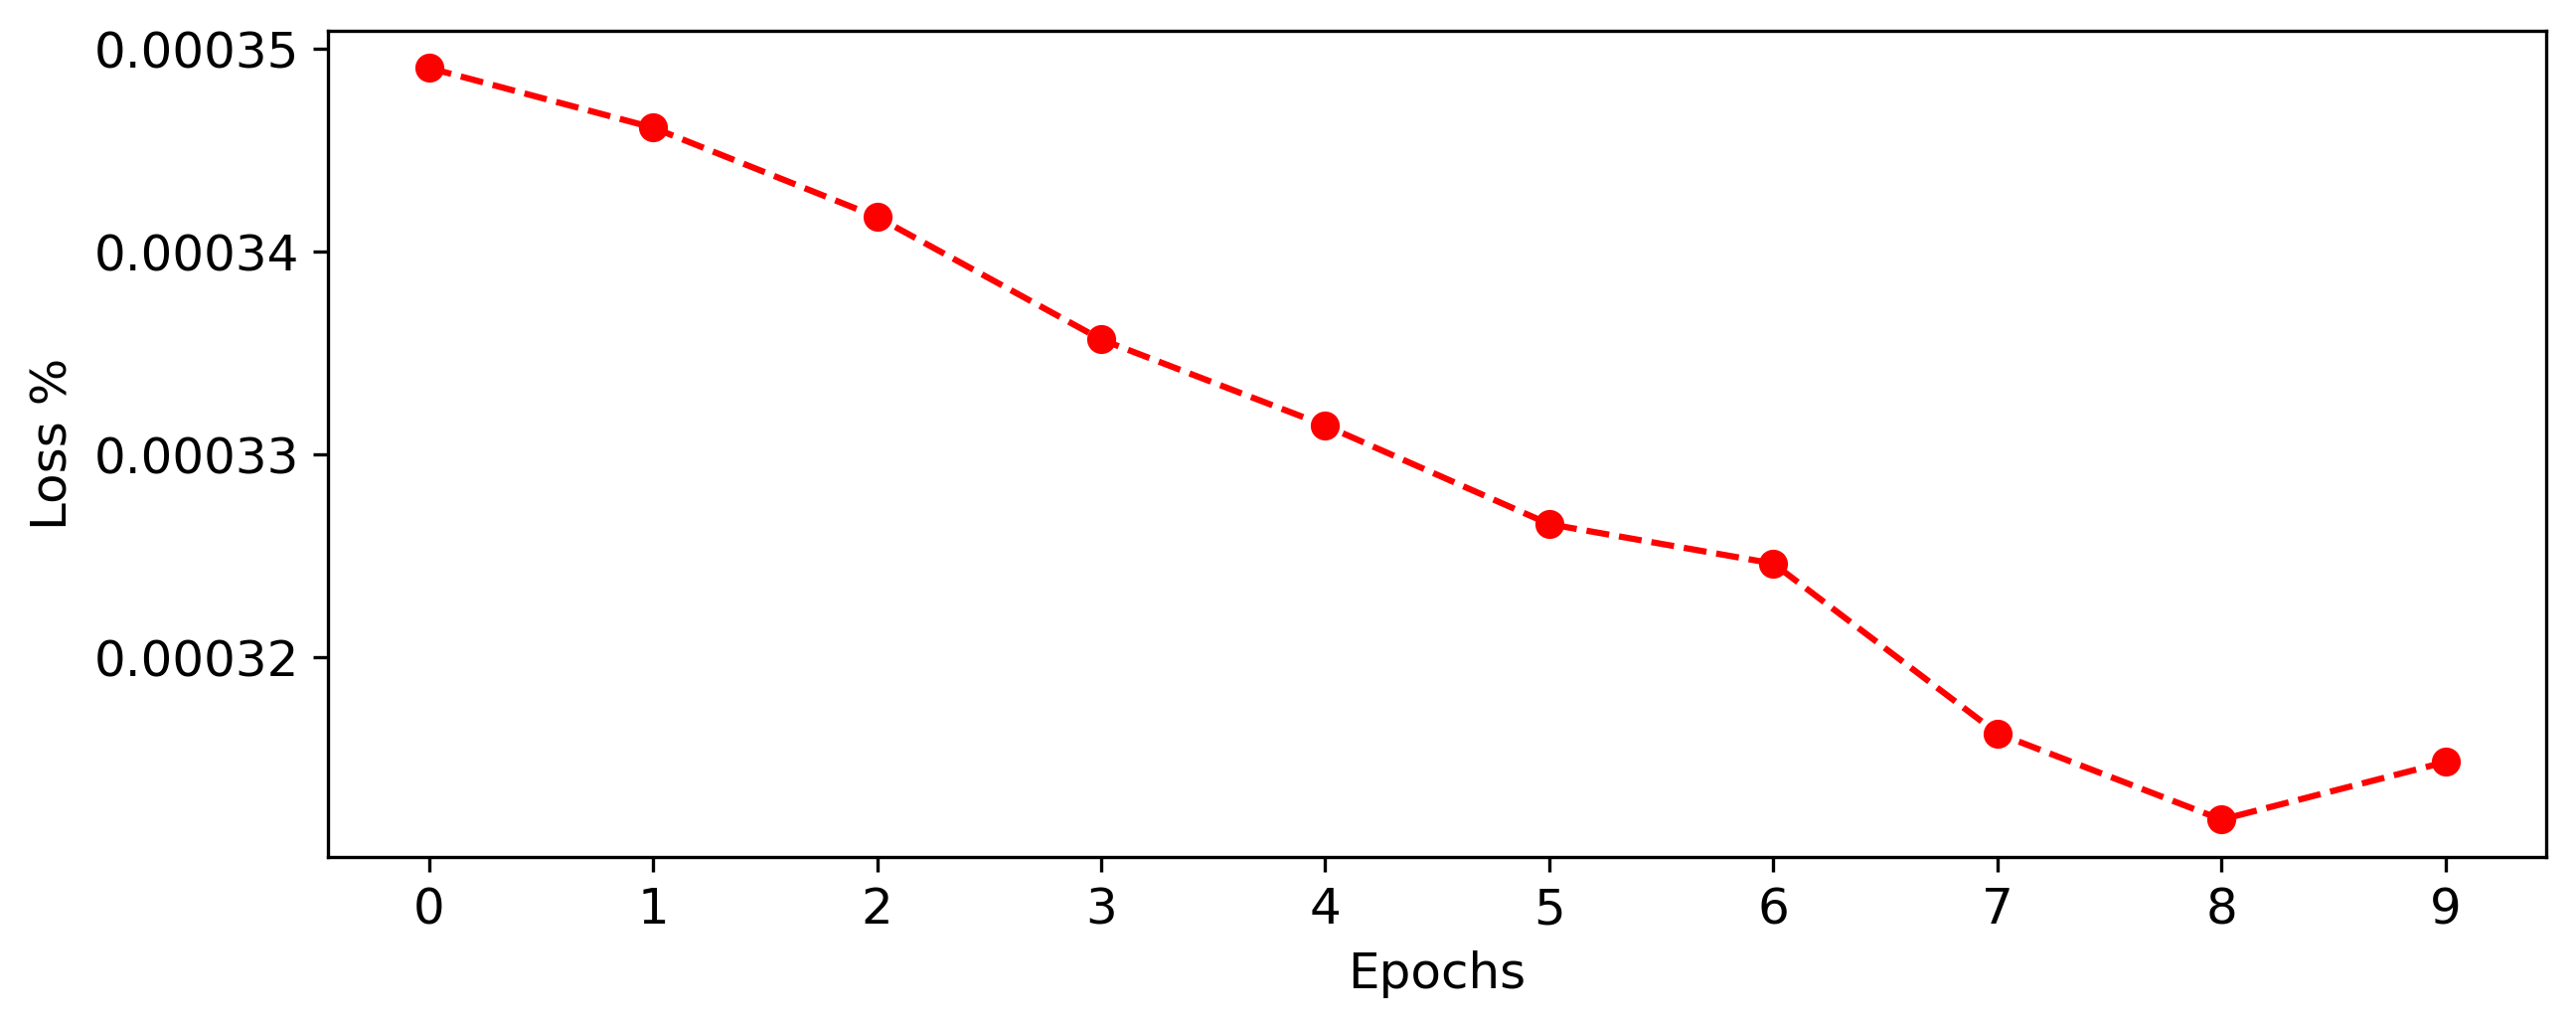

In [24]:
def show_training_loss(loss_per_epoch):
  in_percentage = [loss/100 for loss in loss_per_epoch]
  x= np.arange(len(in_percentage))
  # plt.scatter(x,loss_per_epoch)
  plt.plot(x,loss_per_epoch, 'ro--')
  plt.xticks(ticks=x)
  plt.ylabel('Loss %')
  plt.xlabel('Epochs')
  plt.show()
    
show_training_loss(all_loss_per_epoch)

## Final test accuracy and loss

In [25]:
# - Trained loss and accuracy
print(f'Final test loss {test_loss}, accuracy {test_acc}%')

Final test loss 0.00031483165323734286, accuracy 88.4%


In [26]:
# # - Pull a single test sample and display it
# frame, class_idx = train_data[1]
# data = encode_poisson(frame, num_timesteps)
# target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# plt.figure(figsize=(1, 1))
# plt.imshow(frame[0])
# plt.xticks([])
# plt.yticks([])

# plt.figure()
# b, t, n = torch.nonzero(data, as_tuple = True)
# plt.scatter(t * dt, n, marker='|')
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Input')

# b, t, n = torch.nonzero(target, as_tuple = True)
# plt.figure()
# plt.scatter(t * dt, n, marker='|')
# plt.ylim([-1, num_classes+1])
# plt.xlabel('Time (s)')
# plt.ylabel('Channel')
# plt.title('Target');

In [27]:
# # - Simulate the network with this sample
# output, _, _ = snn.cpu()(data)
# pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()

# # - Display the network output
# b, t, n = torch.nonzero(output, as_tuple=True)

# plt.scatter(t, n, marker='|', label='Output events')
# plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
# plt.plot(100, pred, '<', c='orange', markersize=20, label='Predicted class')
# plt.ylim([-1, num_classes+1])
# plt.xlim([-1, num_timesteps+1])
# plt.xlabel('Time (dt)')
# plt.ylabel('Channel')
# plt.title('Output (events)')
# plt.legend();

# Summary

In [28]:
from tabulate import tabulate

table = [ 
         ['CPU/GPU', str(device) ], 
         ['batch_size', batch_size],
         ['num_of_epochs', num_epochs], 
         ['all_accuracy_per_epoch', all_accuracy_per_epoch],
         ['all_loss_per_epoch', all_loss_per_epoch],
         ['time_per_epoch', time_per_epoch],
         ['final_test_loss', test_loss],
         ['final_test_accuracy', test_acc]]


print(tabulate(table))
import pandas as pd
#Pandas dataframe
d = {'acc_per_epoch': all_accuracy_per_epoch, 'loss_per_epoch': all_loss_per_epoch, 'time_per_epoch' : time_per_epoch}
df = pd.DataFrame(data=d)

print(df)

results_file = "Rockpool_{device}_batch_size_{batch}_num_of_epochs_{epochs}".format(device=device, batch=batch_size, epochs=num_epochs) + ".csv"

df.to_csv(results_file, index=False)


----------------------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CPU/GPU                 cuda
batch_size              256
num_of_epochs           10
all_accuracy_per_epoch  [83.35, 84.68, 84.91, 85.99, 87.07, 87.31, 88.05, 87.63, 88.15, 88.4]
all_loss_per_epoch      [0.0003490492358803749, 0.00034610626697540283, 0.0003417011886835098, 0.0003356621243059635, 0.00033142149820923806, 0.00032656095251441, 0.00032461524978280067, 0.000316244937479496, 0.0003119933743029833, 0.00031483165323734286]
time_per_epoch          [123.14845538139343, 123.15189671516418, 123.96010684967041, 123.37627148628235, 123.67335557937622, 123.02928185462952, 123.21715521812439, 123.12790155410767, 122.88567900657654, 123.24001336097717]
final_test_loss         0.00031483165323734286
final_test_accuracy     88.4
---------